In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import optuna
import joblib
import json

In [2]:
app_train_fe = pd.read_csv("/Users/ibrahimyucel/Downloads/BANKA_PROJE1/app_train_fe.csv")
app_test_fe = pd.read_csv("/Users/ibrahimyucel/Downloads/BANKA_PROJE1/app_test_fe.csv")

In [4]:
train_cols = set(app_train_fe.columns)
test_cols = set(app_test_fe.columns)

only_in_train = train_cols - test_cols
only_in_test = test_cols - train_cols

print("✅ Train'de var, Test'te yok:", only_in_train)
print("✅ Test'te var, Train'de yok:", only_in_test)

# 2. Hangi kolonlar object dtype?
print("\n📌 Train'de object kolonlar:", app_train_fe.select_dtypes(include="object").columns.tolist())
print("\n📌 Test'te object kolonlar:", app_test_fe.select_dtypes(include="object").columns.tolist())

✅ Train'de var, Test'te yok: {'TARGET', 'CNT_FAM_MEMBERS_MISSING_FLAG', 'AMT_GOODS_PRICE_MISSING_FLAG', 'DAYS_LAST_PHONE_CHANGE_MISSING_FLAG'}
✅ Test'te var, Train'de yok: set()

📌 Train'de object kolonlar: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

📌 Test'te object kolonlar: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [5]:
for col in app_train_fe.select_dtypes(include="object").columns:
    le = LabelEncoder()
    combined = pd.concat([app_train_fe[col], app_test_fe[col]], axis=0).astype(str)
    le.fit(combined)
    app_train_fe[col] = le.transform(app_train_fe[col].astype(str))
    app_test_fe[col] = le.transform(app_test_fe[col].astype(str))

X = app_train_fe.drop(columns=["TARGET", "SK_ID_CURR"])
y = app_train_fe["TARGET"]
X_test = app_test_fe.drop(columns=["SK_ID_CURR"])

X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

In [6]:
X = app_train_fe.drop(columns=["TARGET", "SK_ID_CURR"])
y = app_train_fe["TARGET"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "learning_rate": 0.02,
    "num_leaves": 64,
    "max_depth": -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "verbosity": -1,
    "seed": 42,
}

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=["train", "valid"],
    num_boost_round=10000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200)
    ]
)

Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.816867	valid's auc: 0.77592
[400]	train's auc: 0.856812	valid's auc: 0.781922
[600]	train's auc: 0.885959	valid's auc: 0.783841
[800]	train's auc: 0.908581	valid's auc: 0.784983
[1000]	train's auc: 0.925811	valid's auc: 0.78559
[1200]	train's auc: 0.94004	valid's auc: 0.785683
[1400]	train's auc: 0.951591	valid's auc: 0.786199
[1600]	train's auc: 0.960309	valid's auc: 0.786277
[1800]	train's auc: 0.967368	valid's auc: 0.78634
[2000]	train's auc: 0.973483	valid's auc: 0.786312
Early stopping, best iteration is:
[1865]	train's auc: 0.969553	valid's auc: 0.78653


In [7]:
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
auc = roc_auc_score(y_val, y_val_pred)
print("Validation AUC:", auc)

Validation AUC: 0.7867342257880225


In [8]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X))  
models = []                   
auc_scores = []                

pos_weight = (y == 0).sum() / (y == 1).sum()

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"🔹 Fold {fold}")
    
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "learning_rate": 0.02,
        "num_leaves": 64,
        "max_depth": -1,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
        "verbosity": -1,
        "seed": 42,
        "scale_pos_weight": pos_weight
    }

    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_val],
        valid_names=["train", "valid"],
        num_boost_round=5000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=200),
            lgb.log_evaluation(period=200)
        ]
    )

    models.append(model)

    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_idx] = val_pred

    auc = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.5f}")

mean_auc = np.mean(auc_scores)
print(f"\n📊 Mean AUC across {n_splits} folds: {mean_auc:.5f}")

🔹 Fold 1
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.821739	valid's auc: 0.773084
[400]	train's auc: 0.853664	valid's auc: 0.778726
[600]	train's auc: 0.877658	valid's auc: 0.779759
[800]	train's auc: 0.897162	valid's auc: 0.780012
Early stopping, best iteration is:
[720]	train's auc: 0.889783	valid's auc: 0.780244
Fold 1 AUC: 0.78024
🔹 Fold 2
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.819964	valid's auc: 0.781796
[400]	train's auc: 0.852475	valid's auc: 0.787947
[600]	train's auc: 0.876977	valid's auc: 0.789099
[800]	train's auc: 0.896722	valid's auc: 0.788936
Early stopping, best iteration is:
[733]	train's auc: 0.890491	valid's auc: 0.789152
Fold 2 AUC: 0.78915
🔹 Fold 3
Training until validation scores don't improve for 200 rounds
[200]	train's auc: 0.82172	valid's auc: 0.773165
[400]	train's auc: 0.853549	valid's auc: 0.779749
[600]	train's auc: 0.877648	valid's auc: 0.781037
[800]	train's auc: 0.897135	

In [ ]:
pos_weight = (y == 0).sum() / (y == 1).sum()

def objective(trial):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    aucs = []

    param = {
        "objective": "binary",
        "metric": "auc",
        "boosting_type": "gbdt",
        "verbosity": -1,
        "seed": 42,
        "scale_pos_weight": pos_weight, 

        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
    }

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_train, y_train)
        dval = lgb.Dataset(X_val, y_val, reference=dtrain)

        model = lgb.train(
            param,
            dtrain,
            valid_sets=[dtrain, dval],
            num_boost_round=5000,
            callbacks=[
                lgb.early_stopping(stopping_rounds=200),
                lgb.log_evaluation(period=0)  
            ]
        )

        preds = model.predict(X_val, num_iteration=model.best_iteration)
        auc = roc_auc_score(y_val, preds)
        aucs.append(auc)

    return np.mean(aucs)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  #

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

**Best AUC**: 0.7854609073839869


**Best Params**: {
    'learning_rate': 0.02217795985685793,
    'num_leaves': 95,
    'max_depth': 5,
    'min_data_in_leaf': 164,
    'feature_fraction': 0.8417080483379039,
    'bagging_fraction': 0.8628300008332541,
    'bagging_freq': 4,
    'lambda_l1': 1.4000393595354244,
    'lambda_l2': 2.9103175344055554
}

In [8]:
X = app_train_fe.drop(columns=["TARGET", "SK_ID_CURR"])
y = app_train_fe["TARGET"]
X_test = app_test_fe.drop(columns=["SK_ID_CURR"])

X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

# Kolon farklarını kontrol et
train_cols = set(X.columns)
test_cols = set(X_test.columns)

print("Train'de var, Test'te yok:", train_cols - test_cols)
print("Test'te var, Train'de yok:", test_cols - train_cols)

# Hâlâ object kolon kalmış mı?
print("Object kolonlar train:", X.select_dtypes(include='object').columns.tolist())
print("Object kolonlar test:", X_test.select_dtypes(include='object').columns.tolist())

X_train shape: (246008, 333)
X_val shape: (61503, 333)
X_test shape: (48744, 330)
Train'de var, Test'te yok: {'CNT_FAM_MEMBERS_MISSING_FLAG', 'AMT_GOODS_PRICE_MISSING_FLAG', 'DAYS_LAST_PHONE_CHANGE_MISSING_FLAG'}
Test'te var, Train'de yok: set()
Object kolonlar train: []
Object kolonlar test: []


In [17]:
missing_cols = ["CNT_FAM_MEMBERS_MISSING_FLAG", 
                "AMT_GOODS_PRICE_MISSING_FLAG", 
                "DAYS_LAST_PHONE_CHANGE_MISSING_FLAG"]

for col in missing_cols:
    if col not in X_test.columns:
        X_test[col] = 0

X_test = X_test.reindex(columns=X.columns, fill_value=0)

print("Train shape:", X.shape)
print("Test shape:", X_test.shape)
print("Aynı kolon listesi mi? ", list(X.columns) == list(X_test.columns))

Train shape: (307511, 333)
Test shape: (48744, 333)
Aynı kolon listesi mi?  True


In [18]:
# ==============================
# 1. Train & Test veri hazırla
# ==============================
X = app_train_fe.drop(columns=["TARGET", "SK_ID_CURR"])
y = app_train_fe["TARGET"]
X_test = app_test_fe.drop(columns=["SK_ID_CURR"])

# Train ve Test kolonlarını hizala
X, X_test = X.align(X_test, join="left", axis=1, fill_value=0)

# ==============================
# 2. Train / Validation split
# ==============================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

# ==============================
# 3. En iyi parametreler
# ==============================
best_params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "verbosity": -1,
    "seed": 42,
    "scale_pos_weight": (y == 0).sum() / (y == 1).sum(),
    "learning_rate": 0.02217795985685793,
    "num_leaves": 95,
    "max_depth": 5,
    "min_data_in_leaf": 164,
    "feature_fraction": 0.8417080483379039,
    "bagging_fraction": 0.8628300008332541,
    "bagging_freq": 4,
    "lambda_l1": 1.4000393595354244,
    "lambda_l2": 2.9103175344055554
}

# ==============================
# 4. Model eğit
# ==============================
final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    num_boost_round=5000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=200)
    ]
)

# ==============================
# 5. Validation performansı
# ==============================
y_val_pred = final_model.predict(X_val, num_iteration=final_model.best_iteration)
val_auc = roc_auc_score(y_val, y_val_pred)
print("✅ Validation AUC:", val_auc)

# ==============================
# 6. Test seti prediction
# ==============================
y_test_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)

submission = pd.DataFrame({
    "SK_ID_CURR": app_test_fe["SK_ID_CURR"],
    "TARGET": y_test_pred
})

submission.to_csv("submission.csv", index=False)
print("📁 submission.csv dosyası hazır!")


Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.791743	valid_1's auc: 0.774188
[400]	training's auc: 0.810429	valid_1's auc: 0.781674
[600]	training's auc: 0.822198	valid_1's auc: 0.784396
[800]	training's auc: 0.831946	valid_1's auc: 0.786109
[1000]	training's auc: 0.841304	valid_1's auc: 0.787235
[1200]	training's auc: 0.849291	valid_1's auc: 0.787794
[1400]	training's auc: 0.856498	valid_1's auc: 0.788171
[1600]	training's auc: 0.864148	valid_1's auc: 0.788632
[1800]	training's auc: 0.870422	valid_1's auc: 0.788927
[2000]	training's auc: 0.876589	valid_1's auc: 0.788867
Early stopping, best iteration is:
[1850]	training's auc: 0.871972	valid_1's auc: 0.789033
✅ Validation AUC: 0.7890328019365955
📁 submission.csv dosyası hazır!


In [20]:
final_model.save_model("final_model.txt")   # LightGBM formatında
joblib.dump(final_model, "final_model.pkl") # scikit-learn uyumlu format

['final_model.pkl']

In [ ]:
with open("best_params.json", "w") as f:
    json.dump(best_params, f)

/var/folders/1t/15hmc_h12xnbygjnmf7kj43h0000gn/T/ipykernel_7443/2273762631.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df.head(30), x="gain", y="feature", palette="viridis")


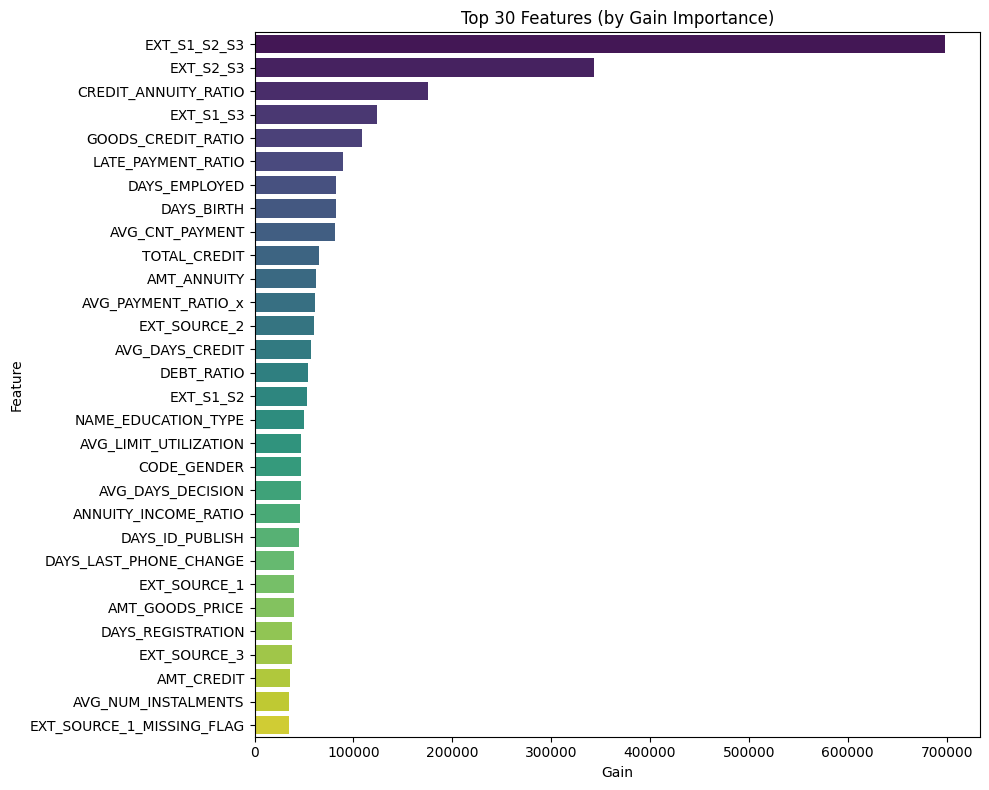

In [22]:
importance_split = final_model.feature_importance(importance_type="split")
importance_gain = final_model.feature_importance(importance_type="gain")
feature_names = final_model.feature_name()

fi_df = pd.DataFrame({
    "feature": feature_names,
    "split": importance_split,
    "gain": importance_gain
})

fi_df = fi_df.sort_values("gain", ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=fi_df.head(30), x="gain", y="feature", palette="viridis")
plt.title("Top 30 Features (by Gain Importance)")
plt.xlabel("Gain")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()